<a href="https://colab.research.google.com/github/sjdonado/covid19-xray-detector/blob/master/covid19_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2

!pip install imutils

from imutils import paths

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
project_path = '/content/gdrive/My Drive/Kaggle/covid19-xray'
dataset_path = project_path + '/dataset'
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'

%cd /content/gdrive/My Drive/Kaggle/covid19-xray

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle/covid19-xray


In [0]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal
mkdir -p input/covid-chest-xray
mkdir -p input/chest-xray-pneumonia/chest_xray

In [0]:
%cd /content/gdrive/My Drive/Kaggle/covid19-xray

/content/gdrive/My Drive/Kaggle/covid19-xray


In [0]:
# download covid dataset

%cd /content/gdrive/My Drive/Kaggle/covid19-xray/input/covid-chest-xray

!kaggle datasets download -d bachrr/covid-chest-xray
!unzip -qq \*.zip
%rm *.zip

/content/gdrive/My Drive/Kaggle/covid19-xray/input/covid-chest-xray
 97% 205M/211M [00:03<00:00, 66.0MB/s]
100% 211M/211M [00:03<00:00, 64.7MB/s]


In [3]:
covid_dataset_path = project_path + '/input/covid-chest-xray'
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["view"] != "PA" or row["finding"]=="No Finding":
        continue
    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]

    if row["finding"] == "COVID-19":
        outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])
    else:
        outputPath = os.path.sep.join([f"{dataset_path}/pneumonia", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

KeyboardInterrupt: ignored

In [0]:
project_path = '/content/gdrive/My Drive/Kaggle/covid19-xray'
dataset_path = project_path + '/dataset'
covid_dataset_path = project_path + '/input/covid-chest-xray'

In [0]:
# download pneumonia dataset
pneumonia_dataset_path = project_path + '/input/chest-xray-pneumonia/chest_xray'
%cd /content/gdrive/My Drive/Kaggle/covid19-xray/input/chest-xray-pneumonia

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -qq \*.zip
%rm *.zip

In [5]:
# build normal xray dataset
samples = 130
random_seed = 42

basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

random.seed(random_seed)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

NameError: ignored

In [0]:
def plots_from_files(imspaths, title, rows=1,width=10,height=5):
    """Plot the images in a grid"""
    f = plt.figure(figsize=(width,height))
    plt.suptitle(title, fontsize=10)
    totalIms = len(imspaths)
    for i in range(totalIms):
        sp = f.add_subplot(rows, -(-totalIms // rows), i + 1)
        sp.axis('Off')
        img = plt.imread(imspaths[i])
        plt.imshow(img)

covid_images = list(paths.list_images(f"{dataset_path}/covid"))
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
pneumonia_images = list(paths.list_images(f"{dataset_path}/pneumonia"))

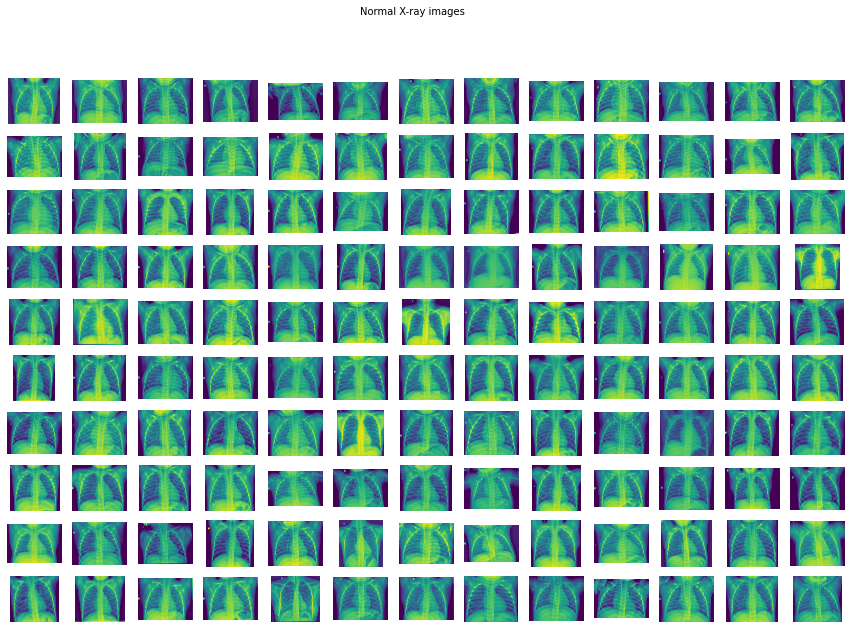

In [0]:
plots_from_files(normal_images, title="Normal X-ray images", rows=10,width=15,height=10)

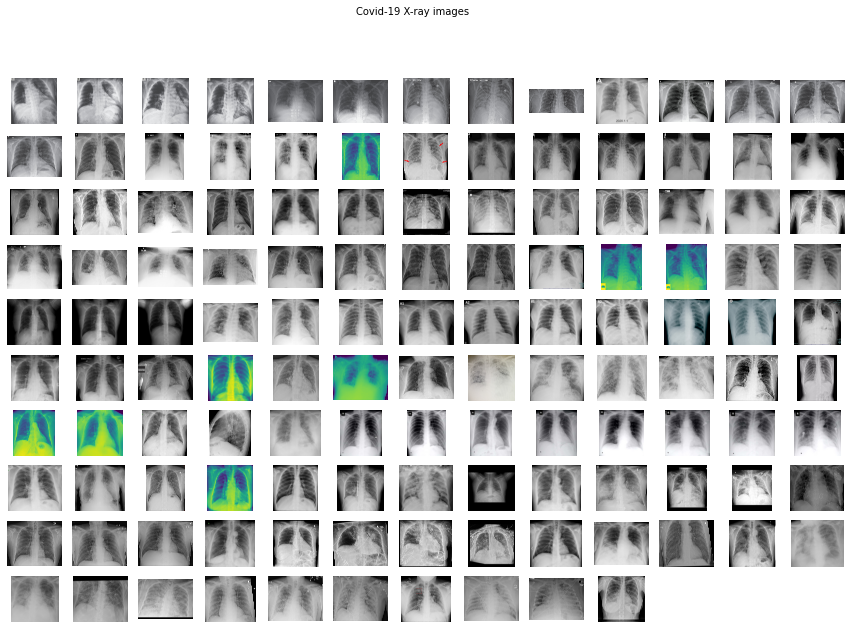

In [0]:
plots_from_files(covid_images, title="Covid-19 X-ray images", rows=10,width=15,height=10)

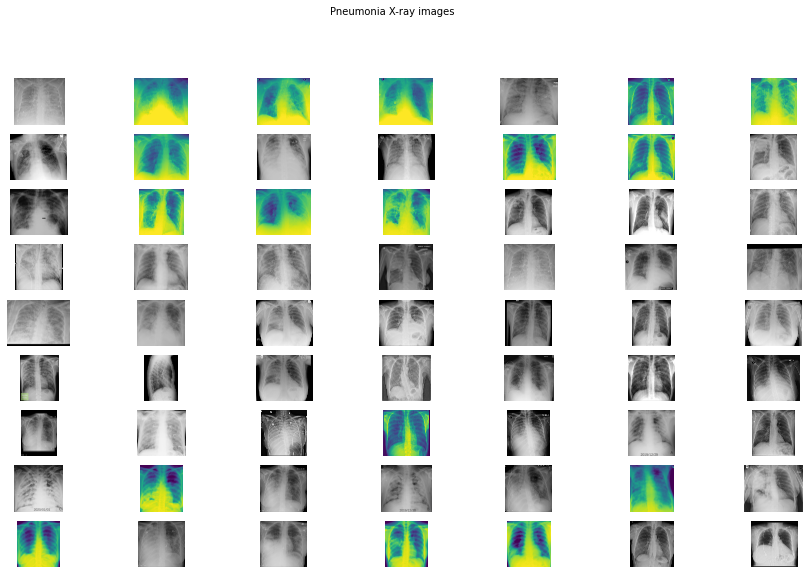

In [9]:
plots_from_files(pneumonia_images, title="Pneumonia X-ray images", rows=10,width=15,height=10)

In [0]:
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    #if imagePath.split(os.path.sep)[-2]=="pneumonia":
     # continue
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
labels = np.array(labels)
data = np.array(data) / 255.0 # normalize dat

In [0]:
print(labels)

[]


In [0]:
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
#from sklearn.preprocessing import label_binarize
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#print(labels2)
#labels3 = to_categorical(labels,num_classes=3)
#print(labels3)

In [0]:
random_seed=42
# split the data (cross-validation 80-20)
from sklearn.model_selection import train_test_split

(X_train, data, y_train, labels) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=random_seed)
(X_val, X_test, y_val, y_test) = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=random_seed)

In [0]:
# build model
from keras.applications.vgg16 import VGG16
from keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from keras.models import Model

# load the VGG16 network, ensuring the head FC layer sets are left
model_vgg16_conv = VGG16(weights="imagenet", include_top=False)
# Make vgg16 model layers as non trainable
for layer in model_vgg16_conv.layers:
    layer.trainable = False

input = Input(shape=(224, 224, 3))
# use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

# add the fully-connected layers
head_model = AveragePooling2D(pool_size=(4, 4))(output_vgg16_conv)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(3, activation="softmax")(head_model)

model = Model(inputs=input, outputs=head_model)

In [0]:
epochs = 10
learning_rate = 1e-3

from keras.optimizers import Adam

opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [0]:
# initialize the training data augmentation object
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [0]:
batch_size = 8

# train the head of the network
history = model.fit_generator(
  train_datagen.flow(X_train, y_train, batch_size=batch_size),
  steps_per_epoch=len(X_train) // batch_size,
  validation_data=(X_val, y_val),
  validation_steps=len(X_val) // batch_size,
  epochs=epochs
)

Epoch 1/10
32/32 [==============================] - 9s 269ms/step - loss: 0.6027 - accuracy: 0.6758 - val_loss: 0.5367 - val_accuracy: 0.7604
Epoch 2/10
32/32 [==============================] - 3s 84ms/step - loss: 0.5027 - accuracy: 0.7760 - val_loss: 0.4779 - val_accuracy: 0.7813
Epoch 3/10
32/32 [==============================] - 3s 85ms/step - loss: 0.4369 - accuracy: 0.8164 - val_loss: 0.4439 - val_accuracy: 0.7604
Epoch 4/10
32/32 [==============================] - 3s 85ms/step - loss: 0.4016 - accuracy: 0.8242 - val_loss: 0.4181 - val_accuracy: 0.7812
Epoch 5/10
32/32 [==============================] - 3s 85ms/step - loss: 0.3842 - accuracy: 0.8268 - val_loss: 0.4035 - val_accuracy: 0.8021
Epoch 6/10
32/32 [==============================] - 3s 87ms/step - loss: 0.3454 - accuracy: 0.8464 - val_loss: 0.3893 - val_accuracy: 0.8125
Epoch 7/10
32/32 [==============================] - 3s 86ms/step - loss: 0.3332 - accuracy: 0.8477 - val_loss: 0.3934 - val_accuracy: 0.8438
Epoch 8/10
3

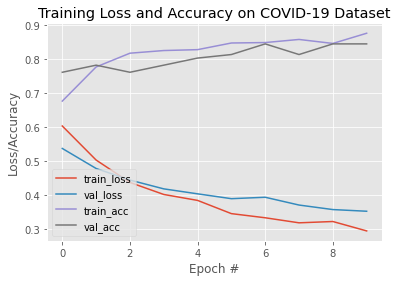

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [0]:
predIdxs = model.predict(X_test, batch_size=batch_size)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

from sklearn.metrics import classification_report

# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.60      1.00      0.75        12
      normal       1.00      0.92      0.96        13
   pneumonia       0.00      0.00      0.00         7

    accuracy                           0.75        32
   macro avg       0.53      0.64      0.57        32
weighted avg       0.63      0.75      0.67        32



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# compute the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}, sensitivity: {:.4f}, specificity: {:.4f}".format(
    accuracy,
    sensitivity,
    specificity
))

[[12  0  0]
 [ 1 12  0]
 [ 7  0  0]]
acc: 0.7500, sensitivity: 1.0000, specificity: 0.9231


In [0]:
print(data)

[[[[0.24313725 0.24313725 0.24313725]
   [0.22745098 0.22745098 0.22745098]
   [0.20392157 0.20392157 0.20392157]
   ...
   [0.22352941 0.22352941 0.22352941]
   [0.23529412 0.23529412 0.23529412]
   [0.29411765 0.29411765 0.29411765]]

  [[0.38039216 0.38039216 0.38039216]
   [0.33333333 0.33333333 0.33333333]
   [0.27058824 0.27058824 0.27058824]
   ...
   [0.34509804 0.34509804 0.34509804]
   [0.41176471 0.41176471 0.41176471]
   [0.44313725 0.44313725 0.44313725]]

  [[0.47058824 0.47058824 0.47058824]
   [0.42745098 0.42745098 0.42745098]
   [0.39607843 0.39607843 0.39607843]
   ...
   [0.48235294 0.48235294 0.48235294]
   [0.52156863 0.52156863 0.52156863]
   [0.52941176 0.52941176 0.52941176]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 